In [49]:
import pandas as pd
import numpy as np
import pickle
import os,gc, math,random


In [50]:
path = "Data/"

In [51]:
X,y = [],[]
for f in os.listdir(path):
    file = open( path + f, 'rb')
    data = pickle.load(file)
    file.close()
    
    imgs,targets=data[0],data[1]
    X+=[img for img in imgs]
    y+=[target for target in targets]

In [52]:
X[0].shape

(10, 10)

In [53]:
X=np.array(X)
y = np.array(y)
gc.collect()

110521

In [54]:
y=pd.Series(y)
y=np.array(y.replace({11:0,13:1,211:2,321:3,2212:4}))
particle_name={0:'electron',1:'muon',2:'pion',3:'kaon',4:'proton'}

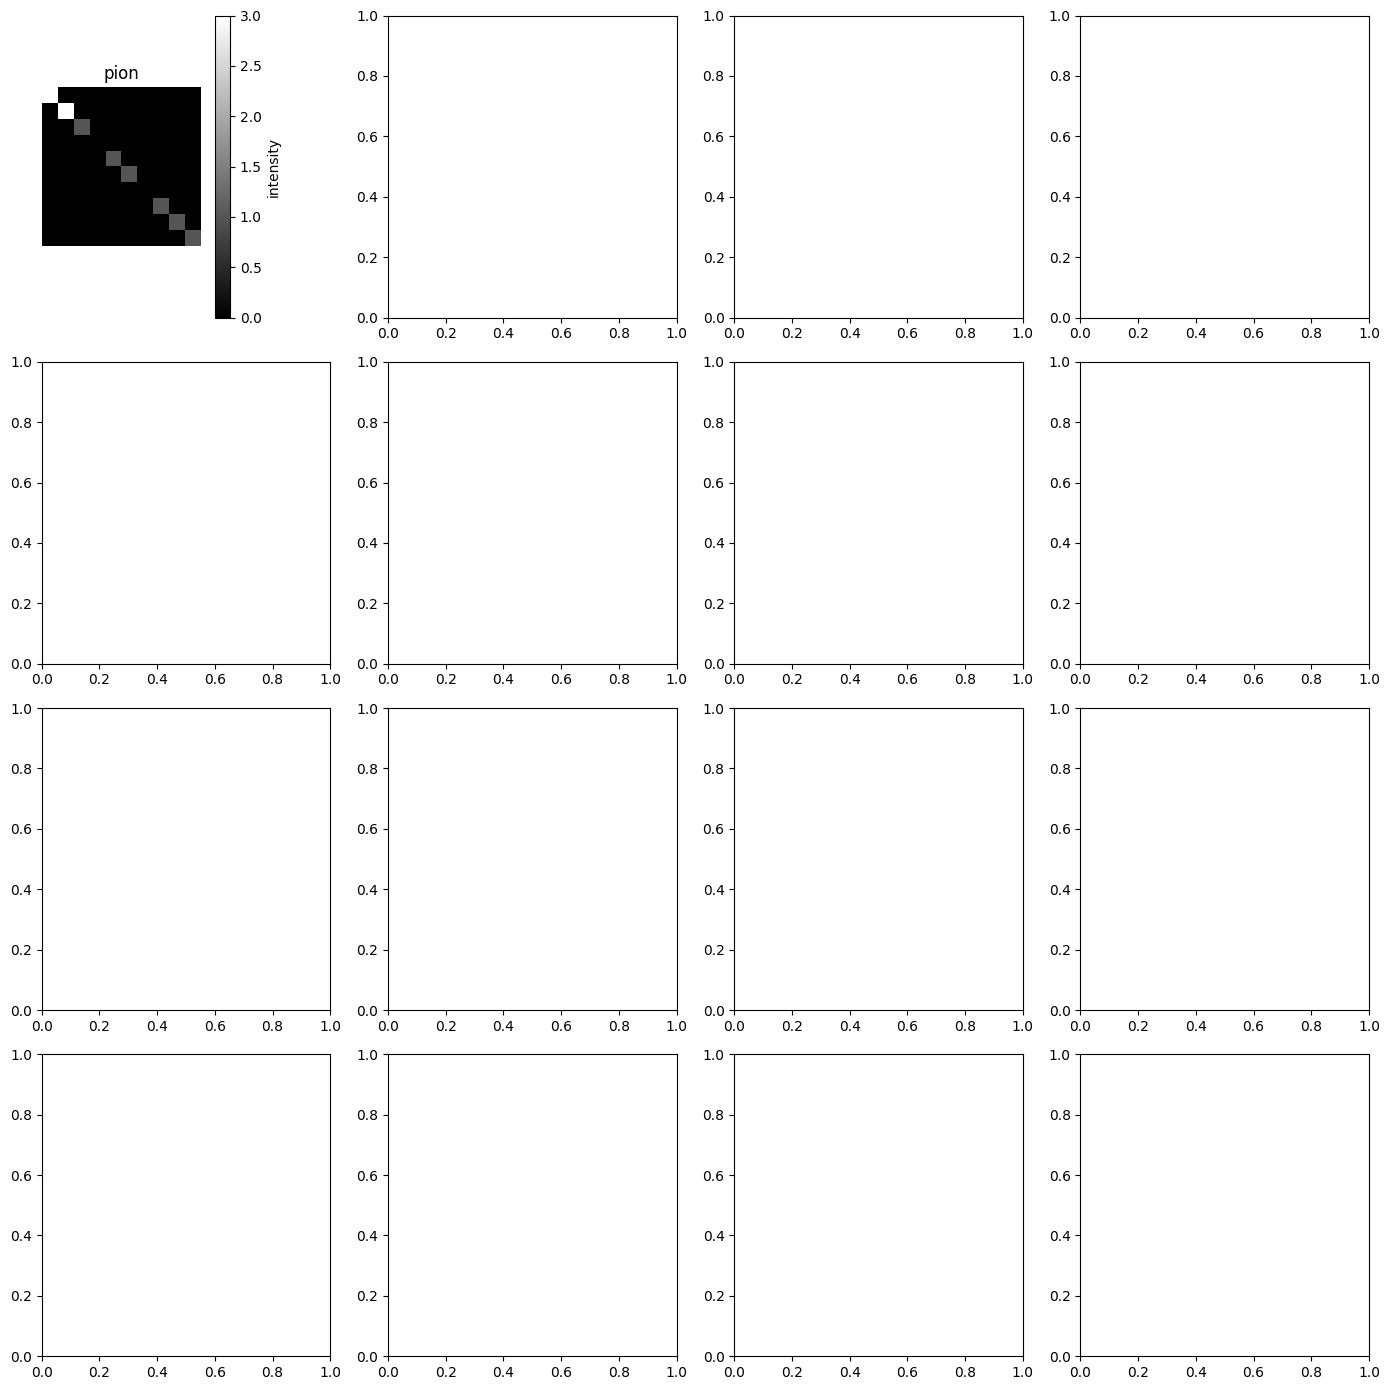

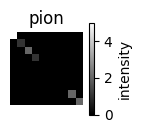

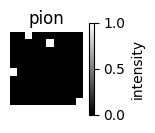

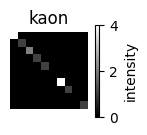

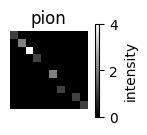

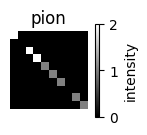

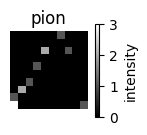

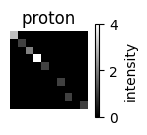

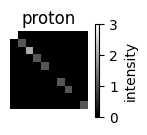

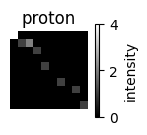

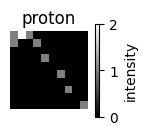

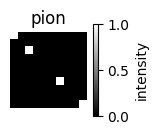

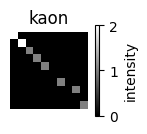

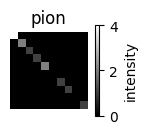

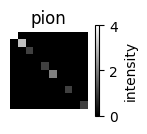

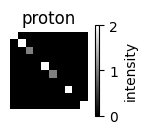

In [55]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(math.floor(n/4),4,figsize=(14,14))
    
    #sampling examples from data
for i in range(16):
    sample_id=random.choice([i for i in range(len(os.listdir(path)))])
        
    #plotting image with particle name:
    plt.subplot(4,4,i+1)
    plt.imshow(X[i],cmap='gray')
    plt.title(f'{particle_name[y[i]]}')
    plt.colorbar(label='intensity',
                fraction=0.4,
                orientation='vertical') 
    plt.axis('off')
    plt.tight_layout()
    plt.grid('off')
    plt.show()

In [56]:
print('The counts of particles:')
pd.Series([particle_name[i] for i in y]).value_counts()

The counts of particles:


pion        906047
kaon        154323
proton      111730
electron      3138
muon          1237
Name: count, dtype: int64

In [57]:
def prepare_images(X):
    inputs=[]
    for image in X:
        image=image/ 12   # scaling using maximum value.
        image=np.expand_dims(image,axis=0)
        inputs.append(image)
    X_t = np.array(inputs)
    X_t=X_t.reshape(X_t.shape[0],X_t.shape[2],X_t.shape[3],X_t.shape[1])
    return X_t 
X_t=prepare_images(X)

In [58]:
print('shape of images: {}'.format(X_t.shape[1:]))
print('Number of images: {}'.format(X_t.shape[0]))

shape of images: (10, 10, 1)
Number of images: 1176475


In [60]:
from sklearn.preprocessing import normalize as norm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

In [61]:
x_train,x_val,y_train,y_val=train_test_split(X_t,y,test_size=0.3,shuffle=True)

In [83]:
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_t.shape[1:])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 8, 8, 64)          640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 4, 4, 64)          0         
                                                                 
 flatten_7 (Flatten)         (None, 1024)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 128)              

In [84]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

reduce_lr=keras.callbacks.ReduceLROnPlateau(factor=0.5,min_delta=1e-2,patience=2,monitor='val_accuracy',verbose=1)

early_stopping=keras.callbacks.EarlyStopping(min_delta=1e-3,patience=10,monitor='val_loss',
                                             restore_best_weights=True)

In [85]:
history=model.fit(x_train,y_train,batch_size=10000,validation_data=(x_val,y_val),epochs=10, callbacks=[reduce_lr,early_stopping])

Epoch 1/10
83/83 [==============================] - 49s 570ms/step - loss: 0.7956 - accuracy: 0.7569 - val_loss: 0.9724 - val_accuracy: 0.7695 - lr: 0.0010
Epoch 2/10
83/83 [==============================] - 49s 593ms/step - loss: 0.7141 - accuracy: 0.7704 - val_loss: 0.8070 - val_accuracy: 0.7695 - lr: 0.0010
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.7704
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
83/83 [==============================] - 51s 620ms/step - loss: 0.7120 - accuracy: 0.7704 - val_loss: 0.7416 - val_accuracy: 0.7695 - lr: 0.0010
Epoch 4/10
83/83 [==============================] - 93s 1s/step - loss: 0.7107 - accuracy: 0.7704 - val_loss: 0.7294 - val_accuracy: 0.7695 - lr: 5.0000e-04
Epoch 5/10
83/83 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.7704
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
83/83 [==============================] - 105s 

In [86]:
filename = 'model.h5'
pickle.dump(model, open(filename, 'wb'))